In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras import regularizers
from keras.metrics import Recall, Precision

%matplotlib inline
tqdm.pandas()

C:\Users\acer\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
train = pd.read_csv('data/train.csv')
sub = pd.read_csv('data/test.csv')

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
sub.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
print(train.loc[13, 'text'])
print(train.loc[1787, 'text'])
print(train.loc[4921, 'text'])

#Flood in Bago Myanmar #We arrived Bago
CLEARED: Crash in Hamilton on I-75 south at MM 459.
Tonight It's Going To Be Mayhem @ #4PlayThursdays. Everybody Free w/ Text. 1716 I ST NW (18+) http://t.co/sCu9QZp6nq


In [8]:
train.shape, sub.shape, sub.shape[0]/train.shape[0]

((7613, 5), (3263, 4), 0.4286089583606988)

In [9]:
train['target'].value_counts() / train['target'].shape[0]

0    0.57034
1    0.42966
Name: target, dtype: float64

In [10]:
def cleaning_text(text):
    
    text = str(text)
    text = text.lower()
    text = re.sub('\W', ' ', text)
    text = re.sub(' +', ' ', text)
    text = word_tokenize(text)
    text = ' '.join([w for w in text if not w in stopwords.words('english')])
    text = text.strip()
    
    return text

In [11]:
# Apply cleaning
train['text_clean'] = train['text'].progress_apply(cleaning_text)

100%|█████████████████████████████████████████████████████████████████████████████| 7613/7613 [00:30<00:00, 252.48it/s]


In [12]:
# Train test split
X_train, X_test, y_train, y_test =  train_test_split(train['text_clean'], 
                                                     train['target'],
                                                     train_size = 0.8,
                                                     stratify = train['target'])

In [13]:
# Keras tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [14]:
# sequence encode
encoded_X_train = tokenizer.texts_to_sequences(X_train)

In [15]:
# pad sequences
max_length = max([len(s.split()) for s in X_train])
encoded_X_train = pad_sequences(encoded_X_train, maxlen=max_length, padding='post')

In [16]:
encoded_X_train

array([[ 1516,   752,  5739, ...,     0,     0,     0],
       [  973,   545,  5745, ...,     0,     0,     0],
       [ 2322,  3745,  2323, ...,     0,     0,     0],
       ...,
       [18330,    68, 18331, ...,     0,     0,     0],
       [18335,   397,  1455, ...,     0,     0,     0],
       [ 1366, 18337,  1166, ...,     0,     0,     0]])

In [17]:
y_train = np.array(y_train)

In [18]:
# define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

18338


In [19]:
# Load Glove embedding
with open('data/glove.6B.100d.txt', encoding='utf-8') as f:
    lines = f.readlines()
embedding = dict()
for line in lines:
    parts = line.split()
    embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')

In [20]:
# Match words in tokenizer with glove
vocab = tokenizer.word_index
embedding_vector = np.zeros((vocab_size, 100))
for word, i in vocab.items():
    vector = embedding.get(word)
    if vector is not None:
        embedding_vector[i] = vector

In [22]:
# Model
model = Sequential([
    Embedding(vocab_size, 100, weights=[embedding_vector], input_length=max_length, trainable=False),
    Conv1D(filters=8, kernel_size=6, kernel_regularizer=regularizers.l2(l=0.01), activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=8, kernel_size=6, kernel_regularizer=regularizers.l2(l=0.01), activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.1),
    Flatten(),
    Dense(1, activation='sigmoid')
])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 27, 100)           1833800   
_________________________________________________________________
conv1d (Conv1D)              (None, 22, 8)             4808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 8)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6, 8)              392       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 8)              0         
_________________________________________________________________
dropout (Dropout)            (None, 3, 8)              0         
_________________________________________________________________
flatten (Flatten)            (None, 24)                0

In [23]:
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[Recall(), Precision()])

In [24]:
# fit network
model.fit(encoded_X_train, y_train, epochs=10, validation_split=0.1, verbose=2)

Epoch 1/10
172/172 - 16s - loss: 0.7026 - recall: 0.6264 - precision: 0.7404 - val_loss: 0.6723 - val_recall: 0.5331 - val_precision: 0.8011
Epoch 2/10
172/172 - 1s - loss: 0.5519 - recall: 0.6985 - precision: 0.8093 - val_loss: 0.5981 - val_recall: 0.6103 - val_precision: 0.7981
Epoch 3/10
172/172 - 1s - loss: 0.5016 - recall: 0.7168 - precision: 0.8351 - val_loss: 0.5650 - val_recall: 0.6875 - val_precision: 0.7450
Epoch 4/10
172/172 - 1s - loss: 0.4820 - recall: 0.7186 - precision: 0.8383 - val_loss: 0.5584 - val_recall: 0.6434 - val_precision: 0.8216
Epoch 5/10
172/172 - 1s - loss: 0.4636 - recall: 0.7356 - precision: 0.8477 - val_loss: 0.5508 - val_recall: 0.6985 - val_precision: 0.7510
Epoch 6/10
172/172 - 1s - loss: 0.4550 - recall: 0.7356 - precision: 0.8561 - val_loss: 0.5560 - val_recall: 0.6066 - val_precision: 0.8505
Epoch 7/10
172/172 - 1s - loss: 0.4458 - recall: 0.7377 - precision: 0.8586 - val_loss: 0.5508 - val_recall: 0.7096 - val_precision: 0.7395
Epoch 8/10
172/172 

In [25]:
# Prepare x and y test
encoded_X_test = tokenizer.texts_to_sequences(X_test)
encoded_X_test = pad_sequences(encoded_X_test, maxlen=max_length, padding='post')
y_test = np.array(y_test)

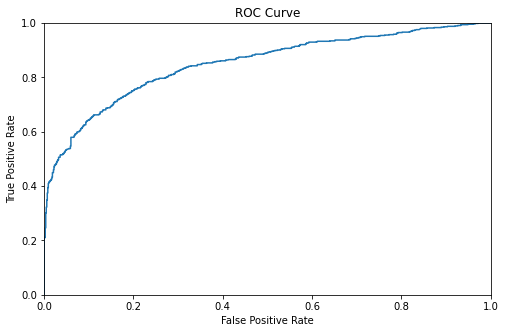

AUC: 0.8499831082864412


In [26]:
# ROC curve
y_pred_prob = model.predict(encoded_X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(8,5))
plt.plot(fpr,tpr) 
plt.axis([0,1,0,1]) 
plt.title('ROC Curve')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.show() 

print('AUC:', roc_auc_score(y_test, y_pred_prob))

In [27]:
# Threshold max tpr - fpr
best_thres = thresholds[list(tpr - fpr).index(max(tpr - fpr))]

In [28]:
# Predict test set
y_pred = model.predict(encoded_X_test).ravel()
y_pred[y_pred>=best_thres] = 1
y_pred[y_pred<best_thres] = 0

In [29]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))

Accuracy: 0.7800393959290873
F1 Score: 0.7471698113207548


In [30]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[693 176]
 [159 495]]
              precision    recall  f1-score   support

           0       0.81      0.80      0.81       869
           1       0.74      0.76      0.75       654

    accuracy                           0.78      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.78      0.78      0.78      1523



In [31]:
# Prepare sub data
sub['text_clean'] = sub['text'].apply(cleaning_text)
encoded_X_sub = tokenizer.texts_to_sequences(sub['text_clean'])
encoded_X_sub = pad_sequences(encoded_X_sub, maxlen=max_length, padding='post')

In [32]:
# Predict submission set
y_sub = model.predict(encoded_X_sub).ravel()
y_sub[y_sub>=best_thres] = 1
y_sub[y_sub<best_thres] = 0

In [33]:
# Save submission
submission = pd.DataFrame({'id':sub['id'], 'target':y_sub})
submission.to_csv('submission.csv', index=False)